<h1> Feature engineering <br>
Modelling <br>
and Evaluation</h2>
<br>
<br>
<b> This is work in progress! </b> <p> Next up is making the pipeline more automated. Scaling the targets. And finetune  the  LSTM, which architeture should it have. How many lags, how many LSTM units, how many  layers, how many perceptrons, which activation functions, and which special layers to add to the architecture. 
<br>
<br>
Radical change: use NIBOR in stead of interest rate, because it is update daily and can give better results.
<h4> Readying the forecast dataset </h4>
Use Ohrnstein Uhlenbeck process to find Food_index price. Use SSB/NB to find forecasts for policy rate. Find some forecasts or eventually use OU-process to find the FX.

<!-- <ol>
<li>Deterministic process</li>
<li>Lagged variables</li>
<li> Fourier</li>
<li>Seasonal indicators (very important)</li>
<li></li>
<li></li>
<li></li>
</ol> -->

<h1> 1. Getting started </h1>
<h2> 1.1 Importing libraries </h2>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer



import tensorflow as tf
from tensorflow import keras
from keras import Sequential, layers, Input, callbacks
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.optimizers import RMSprop


from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.deterministic import  CalendarFourier

from sklearn.metrics import mean_absolute_percentage_error as MAPE

<h2> 1.2 Downloading data </h2>

In [3]:
df = pd.read_csv('Preprocessed_data.csv')
df.index = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.drop(['Date'], axis=1, inplace=True)

<h2> 1.3 Splitting data in 3*2 </h2>
<p> SPlitting data into train, test and validation with the following split: 70 | 15 |15.

In [4]:
y = df['Salmon_exp_vol']
X = df.loc[:,'FX_EURONOK':]

X_train, X_eval, y_train, y_eval = train_test_split(X,y, 
                                                    test_size=0.2,
                                                    shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_eval, y_eval, 
                                                test_size=0.5,
                                                shuffle=False)

<h1> 2. Feature engineering </h1>

<h2> 2.1 Manual imputing </h2>
<p>  Manually fixing NaN, and wrongful observations from the dataset in the training data. </p>

In [5]:
X_train['FX_EURONOK']['2002-10-14'] = 7.34
X_train['FX_EURONOK']['2008-08-04'] = 7.9995
X_train['FX_EURONOK']['2008-08-08'] = 7.9915
X_train['FX_EURONOK']['2008-08-11'] = 7.9975
X_train['FX_EURONOK']['2008-08-18'] = 7.9740

<h2> 2.2 Time dummy and Fourier  </h2>
<p> Creating a time dummy variable. Adding one new colum, where the value goes from 0 to the amount of observations. </p>

In [6]:
def det_process(X, startValue=None):
    # fourier0  =  CalendarFourier(freq='A',  order=3)
    # fourier1  =  CalendarFourier(freq='6M',  order=3)
    # fourier2  =  CalendarFourier(freq='Q',  order=3)

    dp = DeterministicProcess(
        index=X.index,
        constant=True,
        order=1,
        seasonal=True,
        # additional_terms=[fourier0,fourier1,fourier2],
        drop=True
    ) 
    dp = dp.in_sample()
    dp['trend'] += startValue
    new_X = pd.concat([X,dp], axis=1)
    return new_X
time_func = FunctionTransformer(func=det_process, 
                                kw_args={'startValue':None})


<h2> 2.3  Column specific engineering </h2>
<h3> 2.3.1 Log transformation </h3>
<p> Function for log transformation. The FOREX column shows specific characeristics from the lognormal distribution. 

In [7]:
def log_transformation(X):
    X = np.log1p(X)
    X = pd.DataFrame(X)
    return X
log_func = FunctionTransformer(func=log_transformation)

<h3> 2.3.2 Lagging variables </h3>
<p> Creating a function that create specific lagged variables for the datasets. Not going to use this function </p>

In [8]:
def lagged_func_org(X, target=None):
    X_new =  pd.concat([target, X], axis=1)
    # lags = [[1,2,3,4],[13],[1,5],[1,2,3,4]]
    # shift_cols = ['Salmon_exp_vol', 'Interest_rate', 'Food_index', 'FX_EURONOK']
    lags = [[1]]
    shift_cols = ['Salmon_exp_vol']

    sec_it = 0
    lagged_df = pd.DataFrame()
    for n_col in range(len(shift_cols)):
        for n_lag  in range(len(lags[n_col])):
            sec_it+=1
            lagged_df[str(shift_cols[n_col]+
                      '_lag'+
                      str(lags[n_col][n_lag]))] = X_new[shift_cols[n_col]].shift(lags[n_col][n_lag])
    ldf = pd.concat([X,lagged_df],axis=1).dropna()
    return ldf

lagged_func = FunctionTransformer(func=lagged_func_org, 
                                  kw_args={'target':None})

<h2> 2.4  Z-scoring </h2>
<p> Create functions for scaling the variables in a standardized way. </p>

In [9]:
zScore_func = StandardScaler()
zScoreTarget_func = StandardScaler()

<h2> 2.6 Seasonal indicators </h2>
<p> Creating dummy variables for each week in a year. So creating 52 new columns, on for each week. The values are 1 if the observations falls within that week, and zero if not. </p>

In [10]:
def seasonal_indicators(X):
    # weeks = [1,2,3,4,5,6,42,43,44,45,46,47,48,49,50,51,52]
    weeks = np.linspace(1,52,52)
    indicator_df = pd.DataFrame()
    for ind_week in range(len(weeks)):
        column = np.where(X.index.isocalendar().week==weeks[ind_week],1,0)
        indicator_df['IndWeek'+str(weeks[ind_week])] = column
    indicator_df.index = X.index
    new_X = pd.concat([X, indicator_df],axis=1)
    return new_X
indicator_func = FunctionTransformer(func=seasonal_indicators)



<h2> 2.5 Reshaping 2d->3d array </h2>
Function for reshaping the dataset to include timesteps, and transform the data from being 2d to 3d </p>

In [121]:
def reshaper(X, timeSteps=None):
    X = pd.DataFrame(X)
    new_Xs = [np.array(X[timeSteps:])]

    for i in range(1, timeSteps+1,1):
        shift_X  = np.array(X.shift(i))
        new_Xs.append(shift_X[timeSteps:])
    # for i in range(1,timeSteps+1,1):
    #     shift_X  = np.array(X.shift(-i))
    #     new_Xs.append(shift_X[timeSteps:])

    X_reshaped = np.stack(new_Xs, axis=1)
    print(X_reshaped.shape)
    return X_reshaped

reshape_func = FunctionTransformer(func=reshaper, kw_args={'timeSteps':None})

In [12]:
# reshaper(df, 2)

In [13]:
# df.shift(-1)

In [14]:
df.head(3)

,Salmon_exp_vol,FX_EURONOK,Interest_rate,Food_index
Date,,,,
2001-01-01,4089,8.2730,5.5,59.936571
2001-01-08,4959,8.2090,5.5,59.936571
2001-01-15,4610,8.2725,5.5,59.936571


<h1> 3. LSTM model </h1>

In [140]:
np.random.seed(7)


model = keras.Sequential([
    layers.Input(shape=(14,109), name='input_layer'),
    layers.LSTM(200, recurrent_dropout=0.5, return_sequences=True),
    layers.LSTM(200, recurrent_dropout=0.3, return_sequences=True),
    layers.LSTM(200, recurrent_dropout=0.3),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    # layers.BatchNormalization(),
    # layers.Dropout(0.5),
    # layers.Dense(512, activation='gelu'),
    # layers.Dropout(0.3),
    # layers.Dense(256, activation='selu'),
    # layers.Dropout(0.5),
    # layers.Dense(128, activation='relu'),
    layers.Dense(1)
])


optimizer = RMSprop(learning_rate=0.01)  # You can adjust the learning rate as needed
model.compile(optimizer=optimizer,
            #   loss=keras.losses.MeanSquaredError()
              loss = 'mae'
              )

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, 
    patience=15, 
    restore_best_weights=True,
)

<h1> 4.  Pipelining </h1>
<h2> 4.1 Column specific pipeline </h2>

In [123]:
engineering_func = ColumnTransformer(
    transformers=[
        ('loger', log_func, ['FX_EURONOK']),
    ], remainder='passthrough')

<h2> 4.2 Total pipeline </h2>

In [17]:
X_val_corr = pd.concat([X_train[-15:],X_val])
X_test_corr = pd.concat([X_val[-15:],X_test])

In [124]:
pipe = Pipeline(steps=[
    ('det', time_func),
    ('ind', indicator_func),
    ('lag', lagged_func),
    ('Col_spec', engineering_func),
    ('zScore_func', zScore_func),
    ('res', reshape_func)
    # ('lstm', model)
])


pipe.set_params(
                det__kw_args={'startValue':0},
                lag__kw_args={'target':y_train},
                res__kw_args={'timeSteps':13}
                )
X_train_preprocessed  = pipe.fit_transform(X_train)

pipe.set_params(det__kw_args={'startValue':960}, 
                lag__kw_args={'target':y_val},
                res__kw_args={'timeSteps':13})
X_val_preprocessed  = pipe.transform(X_val_corr)

pipe.set_params(det__kw_args={'startValue':1080}, 
                lag__kw_args={'target': y_test},
                res__kw_args={'timeSteps':13})
X_test_preprocessed  = pipe.transform(X_test_corr)


(946, 14, 109)
(106, 14, 109)
(106, 14, 109)


<h1> X. Rest are drafts.. </h1>

In [161]:
# target_scaler = StandardScaler()
# y_train_pre = target_scaler.fit_transform(np.array([y_train[14:]]).T)
# y_val_pre = target_scaler.transform(np.array([y_val[14:]]).T)
# y_test_pre = target_scaler.transform(np.array([y_test[14:]]).T)

y_train_pre = y_train[14:]
y_val_pre = y_val[14:]
y_test_pre =y_test[14:]

In [162]:
def rolling_window_cross_val(model, metric):
    X = np.concatenate((X_train_preprocessed,X_val_preprocessed),axis=0)
    y = np.concatenate((y_train_pre,y_val_pre),axis=0)


    scores = []
    for i in range(0,3,1):
        sel_X = X[int(i*0.316*X.shape[0]):int((i+1)*0.316*X.shape[0])]
        sel_y = y[int(i*0.316*y.shape[0]):int((i+1)*0.316*y.shape[0])]

        sel_X_test = X[int(i*(0.316+0.05)*X.shape[0]):int((i+1)*(0.316+0.05)*X.shape[0])]
        sel_y_test = y[int(i*(0.316+0.05)*y.shape[0]):int((i+1)*(0.316+0.05)*y.shape[0])]
    
        model.fit(sel_X,sel_y,
                epochs=500, batch_size=60,
                validation_data=[sel_X_test, sel_y_test],
                callbacks=early_stopping, verbose=False)        
        pred = model.predict(sel_X_test)
        score = metric(pred, sel_y_test)
        scores.append(score)
    
    return [np.mean(scores),model]

cv_result = rolling_window_cross_val(model,  MAE)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [164]:
cv_result

[12826.386700954594, <Sequential name=sequential_3, built=True>]

In [152]:
# model.fit(X_train_preprocessed,y_train_pre,
#           epochs=500, batch_size=60,
#           validation_data=[X_val_preprocessed, y_val_pre],
#           callbacks=early_stopping)


# train_pred = model.predict(X_train_preprocessed)
# val_pred = model.predict(X_val_preprocessed)
# test_pred = model.predict(X_test_preprocessed)

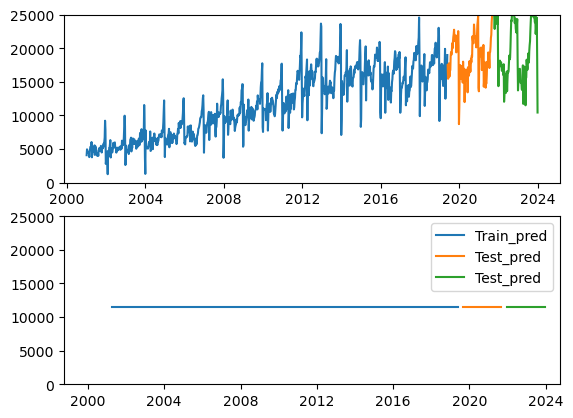

In [24]:
fig,ax = plt.subplots(2)
ax[0].plot(y_train, label='Train')
ax[0].plot(y_val, label='Valid')
ax[0].plot(y_test, label='Test')
ax[0].set_ylim(0,25000)

ax[1].plot(X_train.index[14:], train_pred, label='Train_pred')
ax[1].set_xlim(10500,20000)
ax[1].plot(X_val.index[14:], val_pred, label='Test_pred')
ax[1].plot(X_test.index[14:], test_pred, label='Test_pred')
ax[1].set_ylim(0,25000)

plt.legend()
plt.show()

In [25]:
# from sklearn.metrics import root_mean_squared_error as RMSE
# from sklearn.metrics import mean_absolute_percentage_error as 
from sklearn.metrics import mean_absolute_error as MAE


In [26]:
MAE(train_pred, y_train_pre)

4167.853499108087

In [27]:
1360/11700

0.11623931623931624

In [28]:
train_pred.shape

(946, 1)

In [29]:
(sum(y_train_pre)-sum(train_pred))/ (52*20)

array([148.99230769])

In [30]:
str(X_train.size/1000)+ ' thousands'

'2.88 thousands'

In [31]:
# pd.DataFrame(X_train_preprocessed)

In [32]:
str(X_train_preprocessed.size/1000/1000) +' million'

'2.784078 million'